# Narupa Concepts: Frames


In this notebook, we'll dig into one of the main ideas in Narupa, the **frame**

In [58]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

In [59]:
%matplotlib notebook

## What is a frame?

A frame is our way of representing a molecular system or trajectory in a way that is efficient to send over the network to clients, e.g. the VR app. 

The schematic illustrates this: a Narupa session produces a Frame Data object, whch is serialized and transmitted using [GRPC](https://grpc.io) to client applications.

![Narupa Frame](images/frame_server.png)

A frame is represented as two dictionaries: one of arrays, and one of values. The arrays are used for sending lists of values of the same type, such as particle positions, while the values are used for transmitting single objects, such as numbers, strings or dictionaries.

Let's create a frame for a water molecule. We'll do it by hand.

In [15]:
import numpy as np

In [95]:
# arrange the water molecular O H H 
water_positions = np.array([[0,0,0],[0.075545, 0.047116, 0.00000], [-0.075545, 0.047116, 0.00000 ]])
# elements are defined by their atomic numbers
water_elements = [8, 1, 1]
# Define bonds between the oxygen and the hydrogens.
water_bonds = np.array([[0, 1], [0, 2]])

<IPython.core.display.Javascript object>


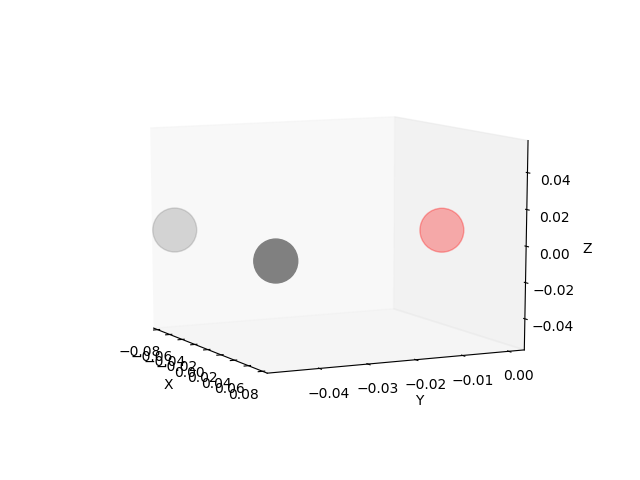

Text(0.5, 0, 'Z')

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(water_positions[:,0], water_positions[:,1], water_positions[:,2], c=['red','gray','gray'], s=1000)
ax.grid(b=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


In [90]:
from narupa.trajectory import FrameData

In [97]:
frame = FrameData()

Now, we put all of this data in by accessing the appropriate storage (arrays or values) and assigning a key.

In [98]:
frame.arrays['particle.positions'] = water_positions.flatten() # We have to store as a flat array.
frame.arrays['particle.elements'] = water_elements
frame.arrays['bond.pairs'] = water_bonds.flatten()

In [99]:
frame.values['particle.count'] = 3

Let's print out the frame, how this looks when communicated to clients. It's just two dictionaries, one with values, one with arrays.

In [100]:
frame.raw

values {
  key: "particle.count"
  value {
    number_value: 3.0
  }
}
arrays {
  key: "bond.pairs"
  value {
    index_values {
      values: 0
      values: 1
      values: 0
      values: 2
    }
  }
}
arrays {
  key: "particle.elements"
  value {
    index_values {
      values: 8
      values: 1
      values: 1
    }
  }
}
arrays {
  key: "particle.positions"
  value {
    float_values {
      values: 0.0
      values: 0.0
      values: 0.0
      values: 0.07554499804973602
      values: 0.0471160002052784
      values: 0.0
      values: -0.07554499804973602
      values: 0.0471160002052784
      values: 0.0
    }
  }
}

To make things easier to use, the python wrapper has shortcuts for common molecular properties:

In [82]:
[attribute for attribute in dir(frame) if not attribute.startswith('_')]

['array_keys',
 'arrays',
 'bond_orders',
 'bond_pairs',
 'box_vectors',
 'chain_count',
 'chain_names',
 'kinetic_energy',
 'particle_count',
 'particle_elements',
 'particle_names',
 'particle_positions',
 'particle_residues',
 'particle_types',
 'potential_energy',
 'raw',
 'residue_chains',
 'residue_count',
 'residue_ids',
 'residue_names',
 'set_float_array',
 'set_index_array',
 'set_string_array',
 'shortcuts',
 'used_shortcuts',
 'value_keys',
 'values']

So we can see what keys have been set: 

In [83]:
frame.array_keys

{'bond.pairs', 'particle.elements', 'particle.positions'}

In [84]:
frame.value_keys

{'particle.count'}

And we could have used the shortcuts to get and set the fields:

In [85]:
frame.particle_count = 3
frame.particle_positions = water_positions
frame.particle_elements = water_elements
frame.bond_pairs = water_bonds

In [86]:
frame.particle_positions

[[0.0, 0.0, 0.0],
 [0.0, 0.07554499804973602, -0.0471160002052784],
 [0.0, -0.07554499804973602, -0.0471160002052784]]

## Transmit it to VR

We've provided enough data to visualize this amazing molecule in VR. So we'll fire up a server and send this frame.

In [73]:
from narupa.app import NarupaFrameApplication

In [74]:
server = NarupaFrameApplication.basic_server(port=0)

In [101]:
server.frame_publisher.send_frame(0, frame)

Connect from VR, and you'll see something like this:

![Narupa H2O](images/h2o.png)

## What kind of data can I send?

You may have noticed that the particle count was transmitted as a `number_value` in the frame, and that the positions were a `float_value`. What kind of values can you send? What kind of arrays can you send? 

### Arrays

For the arrays, you can send decimal number (floats), positive integers (unsigned int) and strings. The types are restricted so we can send them efficiently.

In [138]:
frame.arrays['some floats'] = [1.0, 2.5, 3.5]
frame.arrays['some numbers'] = [1,2,3]
frame.arrays['some strings'] = ['a', 'bc', 'de']

Of course, an array could just be an array of bytes (those in the business call these a `blob`)

In [139]:
with open('images/example_image.jpg', 'rb') as f:
    image_bytes = f.read()

In [140]:
frame.arrays['image'] = image_bytes

In [141]:
server.frame_publisher.send_frame(0, frame)

In [147]:
from narupa.app import NarupaImdClient
from IPython.display import Image

with NarupaImdClient.connect_to_single_server(port=server.port) as client:
    client.wait_until_first_frame()
    received_image_bytes = bytes(client.latest_frame.arrays['image'])

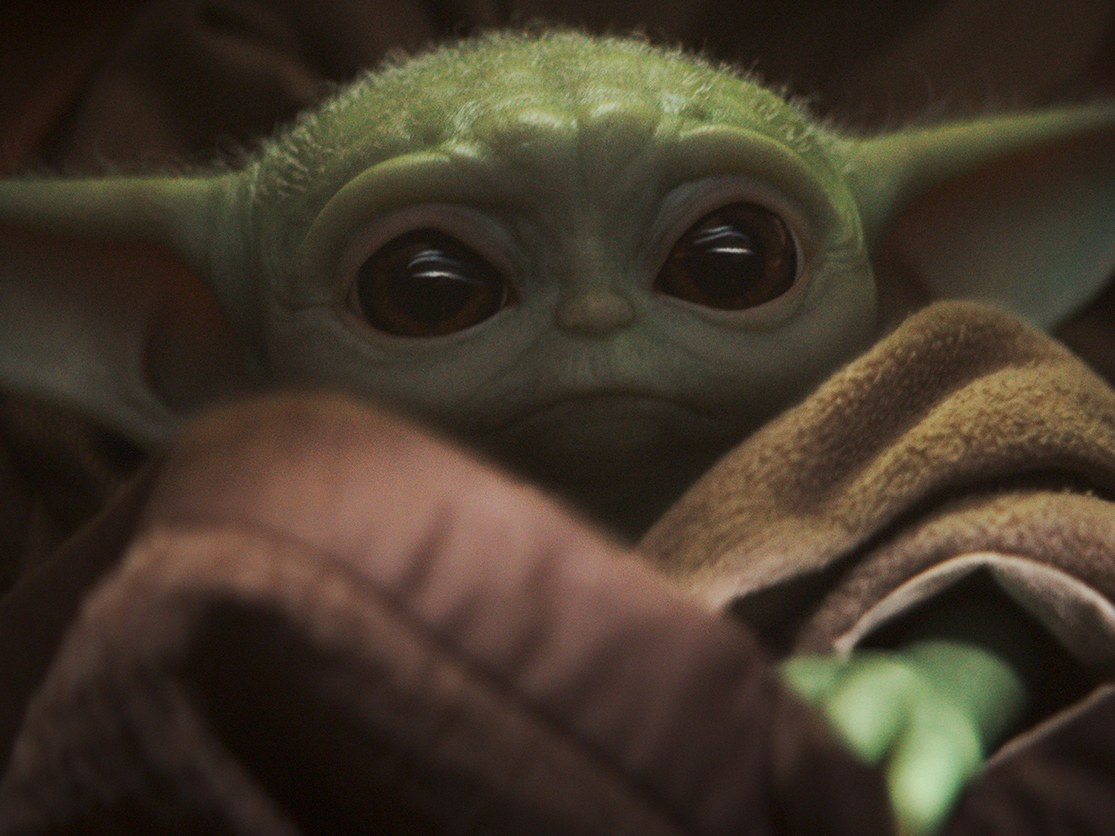

In [148]:
Image(data=received_image_bytes, width=200)

### Values

For the values, you can send anything that can be represented with Protobuf's [Value](https://developers.google.com/protocol-buffers/docs/reference/csharp/class/google/protobuf/well-known-types/value) type. 

This is a very flexible structure, as it can send numbers, strings, bytes, booleans, and lists and `Structs` of these things. A Protobuf `Struct` is analogous to a JSON object. 

We provide some utility methods to help convert these things

In [149]:
from narupa.utilities.protobuf_utilities import dict_to_struct

In [189]:
complicated_object = {
    'name' : 'Squirtle',
    'number' : 7,
    'height' : 0.5,
    'weight' : 9.0,
    'gender' :['male', 'female'],
    'abilities' : ['torrent']
}

#TODO Needs a fix for [this issue](https://gitlab.com/intangiblerealities/narupa-protocol/issues/159) to assign a struct

## More Molecular Data 

As well as the positions, bonds, and elements, we can set additional fields that are commonly available in topological fields formats. If these are passed, lots of exciting rendering and selection opportunites present themselves

The following assigns the water molecule to the residue HOH, in the chain A 

In [193]:
frame.residue_ids = ['1', '1', '1']
frame.residue_names = ['HOH', 'HOH', 'HOH']
frame.residue_count = 1
frame.particle_residues = [0,0,0]
frame.chain_names = ['A']
frame.chain_count = 1
frame.residue_chains = [0]

In [192]:
server.frame_publisher.send_frame(0, frame)

## Updating Data in a Frame

When sending data, the iMD-VR client is intelligent enough to reuse data it has received before, so you don't need to send the everything every time. 

Our convention is to send the topology in the first frame, then just positions after that. The Frame server is smart enough to send the latest version of everything to a client when it first connects.

In the following, we just update the positions array to move the water molecule by 1 nanometer in each cardinal direction

In [196]:
positions_frame = FrameData()
positions_frame.particle_positions = water_positions + 1

In [197]:
server.frame_publisher.send_frame(1, positions_frame)

# Next Steps

* Learn how to set up [commands and synchronise state](commands_and_state.ipynb)
* Learn about the details of setting up [servers](servers.ipynb)
